### Import Data

In [2]:
import requests
import pandas as pd
import hashlib
from pathlib import Path
import gzip
import io

In [83]:
api_url = "https://data.cityofchicago.org/api/v3/views/22u3-xenr/query.json"
params = {"$limit": 10000}
headers = {"portal-App-Token": "5ah8bJgzgJRVbFDfj4VUGVz0s"}
response = requests.get(api_url, headers=headers, params=params)
with open("violation.csv", "wb") as f:
    f.write(response.content)

# raw_bytes = response.content
# with open("violations.csv", "wb") as f:
#     f.write(raw_bytes)

# violations = pd.read_csv("violations.csv")
# violations.head()

In [3]:
import requests
import pandas as pd
from pathlib import Path

Path("data").mkdir(exist_ok=True)

violations_url = "https://data.cityofchicago.org/api/views/22u3-xenr/rows.csv"
permits_url = "https://data.cityofchicago.org/api/views/ydr8-5enu/rows.csv"

params = {"$limit": 1000}

violations_response = requests.get(violations_url, params=params)
violations_path = Path("data/violations.csv")
with open(violations_path, "wb") as f:
    f.write(violations_response.content)

permits_response = requests.get(permits_url, params=params)
permits_path = Path("data/permits.csv")
with open(permits_path, "wb") as f:
    f.write(permits_response.content)

violations_df = pd.read_csv(violations_path)
permits_df = pd.read_csv(permits_path)

print("Violations shape:", violations_df.shape)
print("Permits shape:", permits_df.shape)

Violations shape: (1983943, 26)
Permits shape: (54284, 116)


/var/folders/5c/7mt6q5jx38n0g_yl8g5cygsc0000gn/T/ipykernel_18406/154116451.py:23: DtypeWarning: Columns (85,86,87,88,89,90,91,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  permits_df = pd.read_csv(permits_path)


In [10]:
permits_df.columns = permits_df.columns.str.lower()
permits_df["street_name"]

0         MICHIGAN AVE
1          DIVISION ST
2              16TH ST
3             BROADWAY
4        PRINCETON AVE
             ...      
54279      LONGWOOD DR
54280    PATTERSON AVE
54281          TROY ST
54282    WASHTENAW AVE
54283              NaN
Name: street_name, Length: 54284, dtype: object

In [13]:
violations_df.columns = violations_df.columns.str.lower()
violations_df['street name']

0                 HOYNE
1            COMMERCIAL
2               BUFFALO
3                RACINE
4                 HOYNE
               ...     
1983938         HUBBARD
1983939           CLARK
1983940         NORWOOD
1983941    STONY ISLAND
1983942        CONGRESS
Name: street name, Length: 1983943, dtype: object

In [23]:
violations_df.columns

Index(['id', 'violation last modified date', 'violation date',
       'violation code', 'violation status', 'violation status date',
       'violation description', 'violation location',
       'violation inspector comments', 'violation ordinance', 'inspector id',
       'inspection number', 'inspection status', 'inspection waived',
       'inspection category', 'department bureau', 'address', 'street number',
       'street direction', 'street name', 'street type', 'property group',
       'ssa', 'latitude', 'longitude', 'location'],
      dtype='object')

### Correlation Between Permit Issuances and Violations by Street

In [31]:
permits_df["street name"] = (
    permits_df["street_name"]
        .str.split()
        .str[:-1]
        .str.join(" ")
)
permits_df["only_street_name"]

0         MICHIGAN
1         DIVISION
2             16TH
3                 
4        PRINCETON
           ...    
54279     LONGWOOD
54280    PATTERSON
54281         TROY
54282    WASHTENAW
54283          NaN
Name: only_street_name, Length: 54284, dtype: object

In [32]:
permits_street = permits_df.groupby("street name").size().reset_index(name="num_permits")
violations_street = violations_df.groupby("street name").size().reset_index(name="num_violations")

In [33]:
street_stats = permits_street.merge(violations_street, on="street name", how="inner")

In [35]:
street_stats.corr(numeric_only=True)

,num_permits,num_violations
num_permits,1.000000,0.729098
num_violations,0.729098,1.000000


### Correlation Between Year and Permit Issuances and Number of Violations 

In [25]:
permits_df["year"] = pd.to_datetime(permits_df["issue_date"]).dt.year

In [27]:
violations_df["year"] = pd.to_datetime(violations_df["violation date"]).dt.year

In [28]:
permits_year = permits_df.groupby("year").size().reset_index(name="num_permits")
violations_year = violations_df.groupby("year").size().reset_index(name="num_violations")

In [39]:
year_stats = permits_year.merge(violations_year, on="year", how="inner")
year_stats.corr()

,year,num_permits,num_violations
year,1.000000,0.314481,-0.854979
num_permits,0.314481,1.000000,-0.207660
num_violations,-0.854979,-0.207660,1.000000


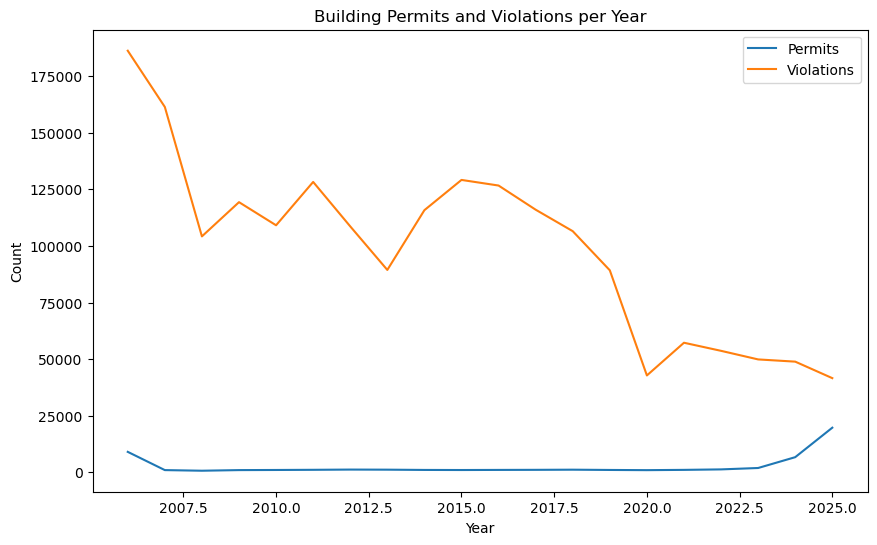

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(year_stats["year"], year_stats["num_permits"], label="Permits")
plt.plot(year_stats["year"], year_stats["num_violations"], label="Violations")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Building Permits and Violations per Year")
plt.legend()
plt.show()


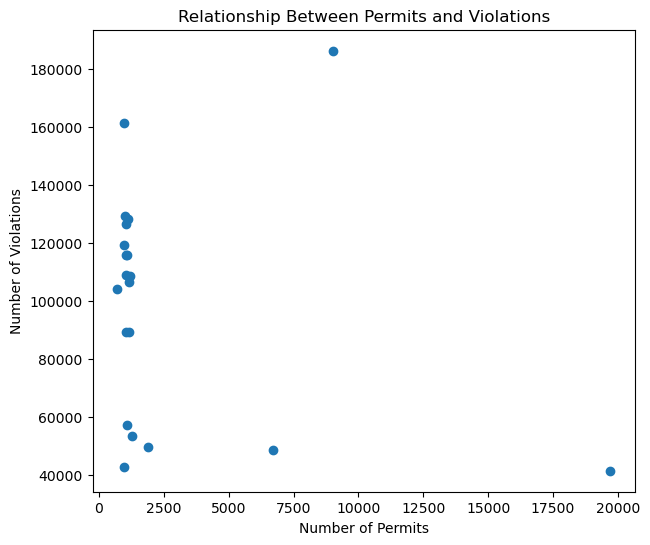

In [41]:
plt.figure(figsize=(7,6))
plt.scatter(year_stats["num_permits"], year_stats["num_violations"])
plt.xlabel("Number of Permits")
plt.ylabel("Number of Violations")
plt.title("Relationship Between Permits and Violations")
plt.show()


In [ ]:
list(violations_df.columns)


['id',
 'violation last modified date',
 'violation date',
 'violation code',
 'violation status',
 'violation status date',
 'violation description',
 'violation location',
 'violation inspector comments',
 'violation ordinance',
 'inspector id',
 'inspection number',
 'inspection status',
 'inspection waived',
 'inspection category',
 'department bureau',
 'address',
 'street number',
 'street direction',
 'street name',
 'street type',
 'property group',
 'ssa',
 'latitude',
 'longitude',
 'location',
 'year']

In [37]:
list(permits_df.columns)

['id',
 'permit#',
 'permit_status',
 'permit_milestone',
 'permit_type',
 'review_type',
 'application_start_date',
 'issue_date',
 'processing_time',
 'street_number',
 'street_direction',
 'street_name',
 'work_type',
 'work_description',
 'permit_condition',
 'building_fee_paid',
 'zoning_fee_paid',
 'other_fee_paid',
 'subtotal_paid',
 'building_fee_unpaid',
 'zoning_fee_unpaid',
 'other_fee_unpaid',
 'subtotal_unpaid',
 'building_fee_waived',
 'building_fee_subtotal',
 'zoning_fee_subtotal',
 'other_fee_subtotal',
 'zoning_fee_waived',
 'other_fee_waived',
 'subtotal_waived',
 'total_fee',
 'contact_1_type',
 'contact_1_name',
 'contact_1_city',
 'contact_1_state',
 'contact_1_zipcode',
 'contact_2_type',
 'contact_2_name',
 'contact_2_city',
 'contact_2_state',
 'contact_2_zipcode',
 'contact_3_type',
 'contact_3_name',
 'contact_3_city',
 'contact_3_state',
 'contact_3_zipcode',
 'contact_4_type',
 'contact_4_name',
 'contact_4_city',
 'contact_4_state',
 'contact_4_zipcode',
 